In [13]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os, json
from pathlib import Path
import datetime
from datetime import datetime as dt

warnings.filterwarnings("ignore")

import os
output_folder = "data/daily"
os.makedirs(output_folder, exist_ok=True)

# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")

def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {e}")

In [14]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})

print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 250
Most Active: 250
Trending: 19
Total unique hot symbols: 487


In [15]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)
    
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

top50 = output_df.head(50)

timestamp = dt.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50


🔥 Saved TOP 50 hot stocks to: data/daily\hot_stocks_20251124101958.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
8,BLTE,120.56,10.423152,250174.0,75618.0,4.206458e+09,3.308392,0.983158,0.991579,0.934737,0.989474,0.977053
23,MOG-A,214.77,8.158330,341164.0,135523.0,6.818850e+09,2.517388,0.949474,0.978947,0.974737,0.987368,0.968632
19,ROST,174.00,8.411215,7821190.0,2460303.0,5.691027e+10,3.178954,0.960000,0.989474,0.957895,0.802105,0.954105
11,LITE,255.59,9.582408,7714645.0,4143700.0,1.812455e+10,1.861777,0.976842,0.903158,0.991579,0.791579,0.935474
42,OSIS,251.10,7.321454,361789.0,201507.0,4.263144e+09,1.795417,0.909474,0.892632,0.981053,0.978947,0.924842
14,GRAL,93.55,9.223586,1988963.0,1048453.0,3.646787e+09,1.897045,0.970526,0.909474,0.901053,0.835789,0.921789
15,DOCS,50.42,8.616980,4141833.0,1607468.0,9.492637e+09,2.576619,0.968421,0.983158,0.771579,0.717895,0.909158
45,BLDR,101.62,7.137590,4740957.0,2044200.0,1.123720e+10,2.319224,0.903158,0.964211,0.873684,0.764211,0.904737
110,PODD,331.17,5.842308,1442987.0,622681.0,2.331190e+10,2.317378,0.766316,0.962105,0.985263,0.960000,0.898000
3,CAVA,48.92,12.227600,8709974.0,4264781.0,5.674041e+09,2.042303,0.993684,0.936842,0.831579,0.538947,0.895895


In [16]:
top50['symbol']

8       BLTE
23     MOG-A
19      ROST
11      LITE
42      OSIS
14      GRAL
15      DOCS
45      BLDR
110     PODD
3       CAVA
13       WGS
4       HTFL
20      SAIA
25      SYNA
64      DAVE
1       ADPT
59       DHI
62       KAI
102      LEN
9        HRI
143     EXPE
41      ALGN
156     IDXX
10        RH
52       MTH
72        ZG
93       MHK
22        BC
76      ODFL
137     ZBRA
2       KYIV
89       GFF
50       UGI
6        WSC
116      BMI
133     NICE
51       CSW
21       GAP
134     PCAR
99      ICUI
79      ATKR
71     LEN-B
152      ZTS
49      ENTG
65       KWR
92        OC
5        TXG
60      CNXC
69      CRCL
95      SITM
Name: symbol, dtype: object

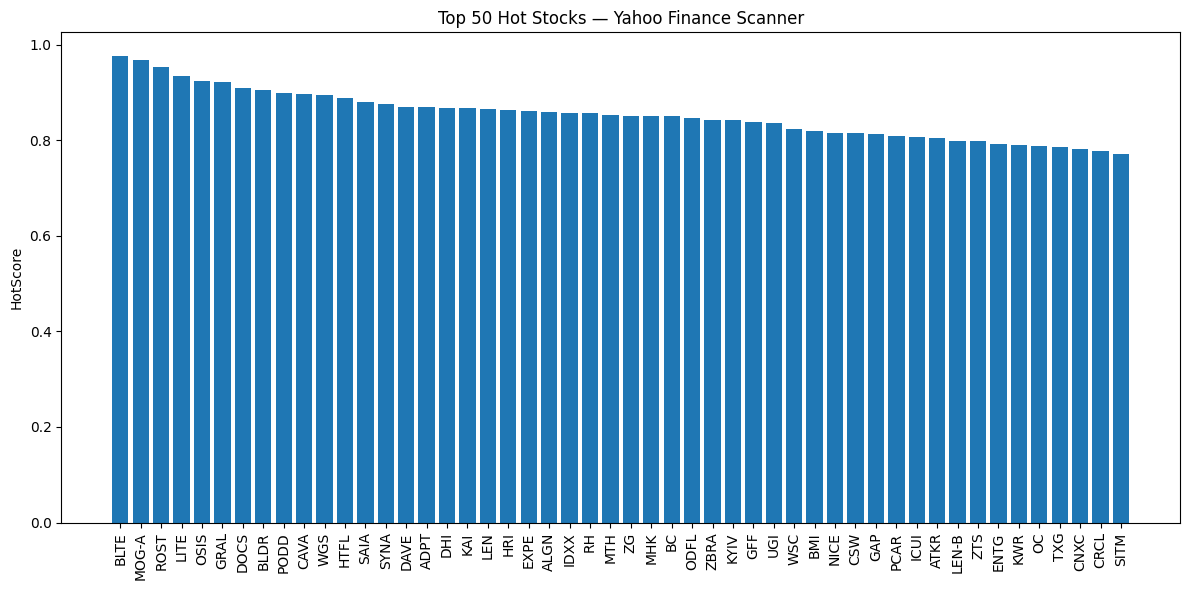

In [17]:
plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()

In [18]:

try:
    top50  # DataFrame with columns including symbol, HotScore, regularMarketPrice, regularMarketChangePercent, regularMarketVolume, VolumeSpike
except NameError:
    raise RuntimeError("Expected DataFrame 'top50' not found. Rename your top50 var or adapt this block.")

# configuration
today = datetime.date.today()
date_str = today.strftime("%Y%m%d") 
timestamp = dt.now().strftime("%Y%m%d%H%M%S")

OUT_DAILY = Path("output/daily")
DATA_DAILY = Path("data/daily")
ML_FOLDER = Path("ml")

for p in (OUT_DAILY, DATA_DAILY, ML_FOLDER):
    p.mkdir(parents=True, exist_ok=True)

# 1) Save top50 CSV
top50_file = DATA_DAILY / f"hot_stocks_{timestamp}.csv"   # keep full timestamp for uniqueness
top50.to_csv(top50_file, index=False)
print("Saved:", top50_file)


# 2) Heatmap of HotScore (symbols x 1 day) -> very small heatmap but useful in dashboard
# We'll produce a horizontal heatmap (symbols on y)
heatmap_file = OUT_DAILY / f"heatmap_hotscore_{date_str}.png"
plt.figure(figsize=(10, max(4, 0.18*len(top50))))
# prepare matrix: each symbol a single value -> use imshow
vals = top50["HotScore"].values.reshape((-1,1))
plt.imshow(vals, aspect='auto', cmap='YlOrRd')
plt.yticks(range(len(top50)), top50["symbol"])
plt.xticks([])
plt.colorbar(label='HotScore')
plt.title(f"HotScore - Top50 - {date_str}")
plt.tight_layout()
plt.savefig(heatmap_file, dpi=200)
plt.close()
print("Saved:", heatmap_file)

# 3) Volume spike bar chart (top50)
vol_file = OUT_DAILY / f"volume_spike_{date_str}.png"
plt.figure(figsize=(12,4))
plt.bar(top50["symbol"], top50["VolumeSpike"])
plt.xticks(rotation=90)
plt.title(f"Volume Spike — Top50 — {date_str}")
plt.tight_layout()
plt.savefig(vol_file, dpi=200)
plt.close()
print("Saved:", vol_file)

# 4) Momentum bar chart (daily percent change)
mom_file = OUT_DAILY / f"momentum_percent_{date_str}.png"
plt.figure(figsize=(12,4))
plt.bar(top50["symbol"], top50["regularMarketChangePercent"])
plt.xticks(rotation=90)
plt.title(f"Momentum (% change today) — Top50 — {date_str}")
plt.tight_layout()
plt.savefig(mom_file, dpi=200)
plt.close()
print("Saved:", mom_file)

# 5) Basic HTML report (table + embedded images) — lightweight single-file
html_file = OUT_DAILY / f"daily_report_{date_str}.html"
html_parts = []
html_parts.append(f"<h1>Daily Hot Stocks — {date_str}</h1>")
html_parts.append(f"<p>Generated at: {timestamp}</p>")
# table top10 in HTML
html_parts.append("<h2>Top 50 (summary)</h2>")
html_parts.append(top50.head(50).to_html(index=False, classes='table table-sm', border=0))

# embed images with relative paths (served from Firebase later)
html_parts.append("<h2>Heatmap</h2>")
html_parts.append(f'<img src="{heatmap_file.name}" alt="heatmap" style="max-width:100%;">')
html_parts.append("<h2>Volume Spike</h2>")
html_parts.append(f'<img src="{vol_file.name}" alt="volume" style="max-width:100%;">')
html_parts.append("<h2>Momentum %</h2>")
html_parts.append(f'<img src="{mom_file.name}" alt="momentum" style="max-width:100%;">')

with open(html_file, "w", encoding="utf-8") as fh:
    fh.write("<html><head><meta charset='utf-8'><title>Daily Hot Stocks</title></head><body>")
    fh.write("\n".join(html_parts))
    fh.write("</body></html>")

print("Saved:", html_file)

# 7) JSON metadata
meta = {
    "date": date_str,
    "timestamp": timestamp,
    "count_top50": len(top50),
    "top_symbols": top50["symbol"].tolist(),
    "files": {
        "daily_top50_csv": str(top50_file),
        "heatmap_png": str(heatmap_file),
        "volume_png": str(vol_file),
        "momentum_png": str(mom_file),
        "html_report": str(html_file)
    }
}
meta_file = DATA_DAILY / f"metadata_daily_{date_str}.json"
with open(meta_file, "w", encoding="utf-8") as fh:
    json.dump(meta, fh, indent=2)
print("Saved:", meta_file)

# 8) ML feature row (append or create)
# We'll extract simple features from the top50 for ML: symbol, price, HotScore, volume spike, momentum
ml_row = top50[["symbol","regularMarketPrice","HotScore","VolumeSpike","regularMarketChangePercent"]].copy()
ml_row["date"] = date_str
ml_path = ML_FOLDER / f"features_{date_str}.csv"
ml_row.to_csv(ml_path, index=False)
print("Saved:", ml_path)

print("\nDaily outputs completed. Files saved to 'output/daily' and 'data/daily'.")

Saved: data\daily\hot_stocks_20251124101959.csv
Saved: output\daily\heatmap_hotscore_20251124.png
Saved: output\daily\volume_spike_20251124.png
Saved: output\daily\momentum_percent_20251124.png
Saved: output\daily\daily_report_20251124.html
Saved: data\daily\metadata_daily_20251124.json
Saved: ml\features_20251124.csv

Daily outputs completed. Files saved to 'output/daily' and 'data/daily'.
